# SusieR benchmark

A first (comprehensive) set of simulations to learn properties of the new fine-mapping method.

As a first pass, we run `susie` on simulations of 100 genes, with 

- real genotypes, of length 1000 for starters
- randomly-chosen SNPs as eQTLs
- 1-5 eQTLs per gene
- explaining 5-40% of the variance in Y

We characterize 95% confident sets (CS) it produces in terms of

- size: number of variants in it
- purity: min, median or mean LD (turns out we can live with using min)
- significance: lfsr of a CS
- false discovery: whether or not they capture a signal

and, to compare with other methods

- power: whether or not all simulated signals are captured
- PIP consistency: whether or not 

We run Susie with

- `estimate_residual_variance`: TRUE and FALSE
- `prior_variance`: 5-40%

We should expect that results will be reasonably robust to these choices.

In [1]:
%cd ~/GIT/github/mvarbvs/dsc

/home/gaow/GIT/github/mvarbvs/dsc

In [ ]:
dsc susie.dsc --target run_susie -c 20

## Utility function

In [10]:
get_combined = function(sub, dirname, ld_col, ld_cutoff = 0.2, lfsr_cutoff = 0.05) {
    out_files = sub[,c("fit_susie.output.file", "plot_susie.output.file")]
    combined = list(purity = NULL, lfsr = NULL, size = NULL, 
                    captures = NULL, total_captures = NULL, pip = NULL)
    for (i in 1:nrow(out_files)) {
        fit = readRDS(paste0(dirname, out_files[i,1], '.rds'))$posterior
        purity = readRDS(paste0(dirname, out_files[i,2], '.rds'))
        #
        if (is.null(combined$purity)) combined$purity = purity$purity$V1[,ld_col]
        else combined$purity = cbind(combined$purity, purity$purity$V1[,ld_col])
        #
        if (is.null(combined$size)) combined$size = fit$n_in_CI[,1]
        else combined$size = cbind(combined$size, fit$n_in_CI[,1])
        #
        if (is.null(combined$lfsr)) combined$lfsr = fit$set_lfsr[,1]
        else combined$lfsr = cbind(combined$lfsr, fit$set_lfsr[,1])
        #
        alpha = fit$alpha[which(purity$purity$V1[,ld_col] > ld_cutoff),,drop=FALSE]
        pip = t(1 - apply(1 - alpha, 2, prod))
        if (is.null(combined$pip)) combined$pip = pip
        else combined$pip = cbind(combined$pip, pip)        
        #
        if (is.null(combined$captures)) combined$captures = rowSums(purity$signal$V1)
        else combined$captures = cbind(combined$captures, rowSums(purity$signal$V1))
        #
        detected = apply(t(purity$signal$V1[which(fit$set_lfsr[,1] < lfsr_cutoff),,drop=FALSE]), 1, sum)
        if (is.null(combined$total_captures)) combined$total_captures = detected
        else combined$total_captures = combined$total_captures + detected
    }
    return(combined)
}

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='talk')

COLORS = ['#348ABD', '#7A68A6', '#A60628', '#467821', '#FF0000', '#188487', '#E2A233',
              '#A9A9A9', '#000000', '#FF00FF', '#FFD700', '#ADFF2F', '#00FFFF']
color_mapper = np.vectorize(lambda x: dict([(i,j) for i,j in enumerate(COLORS)]).get(x))

def plot_purity(data, output, lfsr_cutoff = 0.05):
    purity = np.array(data['purity'])
    lfsr = np.array(data['lfsr'])
    size = np.array(data['size'])
    capture = np.array(data['captures'])
    capture_summary = [f"Signal {idx+1} captured {item}/{purity.shape[1]} times" for idx, item in enumerate(data['total_captures'])]
    idx = 0
    plt.figure(figsize=(12, 8))
    L = purity.shape[0]
    cols = 3
    rows = L // cols + L % cols
    position = range(1,L + 1)
    for x, y, z, c in zip(size, purity, lfsr, capture):
        z_sig = [i for i, zz in enumerate(z) if zz <= lfsr_cutoff]
        z_nsig = [i for i, zz in enumerate(z) if zz > lfsr_cutoff]
        colors = [4 if i == 0 else 0 for i in c]
        plt.subplot(rows,cols,position[idx])
        idx += 1
        if len(z_sig):
            label = f'{idx}: lfsr<={lfsr_cutoff}'
            plt.scatter(np.take(x, z_sig),
                        np.take(y, z_sig),
                        c = color_mapper(np.take(colors, z_sig)), 
                        label = label, marker = '*')
        if len(z_nsig):
            label = f'{idx}: lfsr>{lfsr_cutoff}'
            plt.scatter(np.take(x, z_nsig),
                        np.take(y, z_nsig),
                        c = color_mapper(np.take(colors, z_nsig)), 
                        label = label, marker = 'x')   
        plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2, handletextpad=0.1)
    plt.subplots_adjust(hspace=0.3, wspace = 0.3)
    plt.suptitle(f"95% CI set sizes vs min(abs(LD))\n{'; '.join(capture_summary)}")
    plt.savefig(output, dpi=500, bbox_inches='tight')                    
    plt.gca()

## Results

In [2]:
out = dscrutils::dscquery('benchmark', 
                    target = "liter_data.dataset simple_lm.pve simple_lm.n_signal fit_susie.estimate_residual_variance fit_susie.prior_var fit_susie plot_susie")

Loading dsc-query output from CSV file.


In [59]:
head(out)

DSC,liter_data.dataset,simple_lm.pve,simple_lm.n_signal,fit_susie.estimate_residual_variance,fit_susie.prior_var,fit_susie.output.file,eval_susie.output.file
1,~/Documents/GTExV8/Thyroid.Lung.FMO2.filled.rds,0.05,1,FALSE,0.05,fit_susie/liter_data_1_summarize_ld_1_simple_lm_1_fit_susie_1,eval_susie/liter_data_1_summarize_ld_1_simple_lm_1_fit_susie_1_eval_susie_1
1,~/Documents/GTExV8/Thyroid.Lung.FMO2.filled.rds,0.05,1,FALSE,0.10,fit_susie/liter_data_1_summarize_ld_1_simple_lm_1_fit_susie_3,eval_susie/liter_data_1_summarize_ld_1_simple_lm_1_fit_susie_3_eval_susie_1
1,~/Documents/GTExV8/Thyroid.Lung.FMO2.filled.rds,0.05,1,FALSE,0.20,fit_susie/liter_data_1_summarize_ld_1_simple_lm_1_fit_susie_5,eval_susie/liter_data_1_summarize_ld_1_simple_lm_1_fit_susie_5_eval_susie_1
1,~/Documents/GTExV8/Thyroid.Lung.FMO2.filled.rds,0.05,1,FALSE,0.40,fit_susie/liter_data_1_summarize_ld_1_simple_lm_1_fit_susie_7,eval_susie/liter_data_1_summarize_ld_1_simple_lm_1_fit_susie_7_eval_susie_1
1,~/Documents/GTExV8/Thyroid.Lung.FMO2.filled.rds,0.05,1,TRUE,0.05,fit_susie/liter_data_1_summarize_ld_1_simple_lm_1_fit_susie_2,eval_susie/liter_data_1_summarize_ld_1_simple_lm_1_fit_susie_2_eval_susie_1
1,~/Documents/GTExV8/Thyroid.Lung.FMO2.filled.rds,0.05,1,TRUE,0.10,fit_susie/liter_data_1_summarize_ld_1_simple_lm_1_fit_susie_4,eval_susie/liter_data_1_summarize_ld_1_simple_lm_1_fit_susie_4_eval_susie_1


In [8]:
dim(out)

[1] 8000    8

It is a lot of results to look at. Here we focus on PVE 20% and 40%, having 2, 3, 5 signals, with prior set to `0.2`. We focus on measuring "purity" by min(abs(LD)).

### 2 signals + 20% PVE + `est_residual=FALSE`

In [4]:
pve = 0.2
n = 2
est_res = FALSE
prior = 0.2
ld_col = 1 # LD_Min
lfsr_cutoff = 0.05
dirname = 'benchmark/'
sub = out[which(out$simple_lm.pve == pve & out$simple_lm.n_signal == n & out$fit_susie.estimate_residual_variance == est_res & out$fit_susie.prior_var == prior),]

In [11]:
combined = get_combined(sub, dirname, ld_col)
combined

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.r

9.786503e-01,1.000000e+00,8.937027e-01,0.9395684,8.906681e-01,0.9220091,5.495667e-01,9.890658e-01,1.000000e+00,0.975937,⋯,1.000000e+00,9.290953e-01,1.000000e+00,7.43524e-41,0.6812314,9.876343e-01,0.9843765,3.619155e-41,9.997102e-01,9.824947e-01
9.470233e-01,6.311396e-01,8.847574e-41,0.2192256,4.022586e-41,1.0000000,8.602727e-41,7.491451e-01,1.000000e+00,1.000000,⋯,7.734674e-42,6.084654e-43,1.120709e-41,7.43524e-41,0.0000000,9.591960e-01,0.8948304,3.619155e-41,5.917342e-01,6.663029e-39
1.193006e-13,8.045955e-41,8.847574e-41,0.0000000,4.022586e-41,0.0000000,8.602727e-41,1.248134e-42,2.657076e-40,0.000000,⋯,7.734674e-42,6.084654e-43,1.120709e-41,7.43524e-41,0.0000000,1.433117e-41,0.0000000,3.619155e-41,3.464381e-41,6.663029e-39
1.193006e-13,8.045955e-41,8.847574e-41,0.0000000,4.022586e-41,0.0000000,8.602727e-41,1.248134e-42,2.657076e-40,0.000000,⋯,7.734674e-42,6.084654e-43,1.120709e-41,7.43524e-41,0.0000000,1.433117e-41,0.0000000,3.619155e-41,3.464381e-41,6.663029e-39
1.193006e-13,8.045955e-41,8.847574e-41,0.0000000,4.022586e-41,0.0000000,8.602727e-41,1.248134e-42,2.657076e-40,0.000000,⋯,7.734674e-42,6.084654e-43,1.120709e-41,7.43524e-41,0.0000000,1.433117e-41,0.0000000,3.619155e-41,3.464381e-41,6.663029e-39
2,1,30,40,8,11,127,3,38,5,⋯,1,9,4,914,9,12,7,897,28,4
13,5,915,28,930,1,935,4,4,1,⋯,904,924,927,913,923,15,4,894,4,934
933,932,914,945,929,939,934,951,942,944,⋯,948,923,926,913,923,951,936,894,950,934
933,932,914,945,929,939,934,951,942,944,⋯,948,925,926,914,923,951,936,895,950,934
933,932,915,945,930,939,935,951,942,944,⋯,948,927,927,914,923,951,936,897,950,934
1,0,1,1,1,1,1,1,1,1,⋯,1,1,0,2,1,1,1,2,1,1


In [50]:
saveRDS(combined, '../data/20180516_susie_bm.rds')

In [51]:
dsc-io ../data/20180516_susie_bm.rds ../data/20180516_susie_bm.pkl

In [1]:
import pickle
data = pickle.load(open('../data/20180516_susie_bm.pkl', 'rb'))

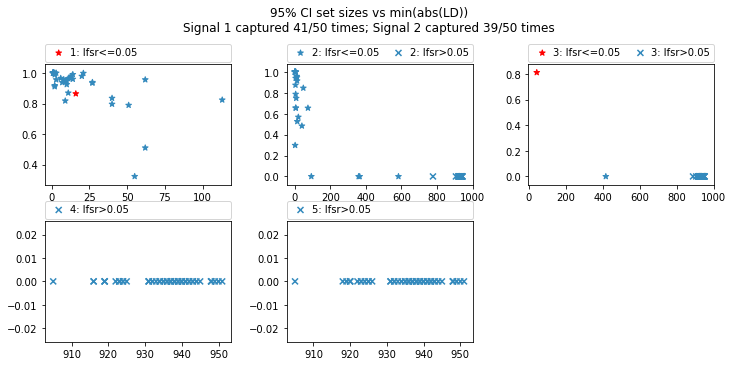

In [55]:
plot_purity(data, '2_p2pve_false.png')

In [28]:
import numpy as np
cs_capture_status = np.array(data['captures'][np.where(data['purity'] > 0.2)]).ravel()

In [29]:
sum(cs_capture_status > 0) / len(cs_capture_status)

0.96